<a href="https://colab.research.google.com/github/dnlgnwn-wq/Kelompok3_RandomForest_MachineLearning/blob/main/Prediksi_Mobil_BMW_Random_Forest_Daniel_UTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

LOAD DARASET

In [2]:
df = pd.read_csv("/content/bmw.csv", sep=';')
print("5 data teratas:")
display(df.head())

5 data teratas:


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


CEK DATA DUPLIKAT

In [3]:
# Cek data kosong (null)
print("=== CEK DATA NULL ===")
print(df.isnull().sum())

# Cek duplikat
print("\nJumlah duplikat:", df.duplicated().sum())

# Hapus duplikat jika ada
df = df.drop_duplicates()

=== CEK DATA NULL ===
model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

Jumlah duplikat: 117


MEMISAHKAN FITUR DAN LABEL

In [4]:
# Tentukan fitur dan label
X = df[['year', 'price', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize']]
y = df['model']

# Encode label menjadi angka
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Cek hasil encoding
print("Contoh encoding:", list(zip(y[:9], y_encoded[:9])))

Contoh encoding: [(' 5 Series', np.int64(4)), (' 6 Series', np.int64(5)), (' 5 Series', np.int64(4)), (' 1 Series', np.int64(0)), (' 7 Series', np.int64(6)), (' 5 Series', np.int64(4)), (' 5 Series', np.int64(4)), (' 2 Series', np.int64(1)), (' 4 Series', np.int64(3))]


BALANCING SMOTE

In [5]:
# Pastikan kolom kategorikal diencode terlebih dahulu
X_encoded = pd.get_dummies(X, columns=['transmission', 'fuelType'])

# Cek distribusi sebelum SMOTE
print("=== Distribusi Sebelum Balancing ===")
print(pd.Series(y_encoded).value_counts())

# Terapkan SMOTE hanya pada data numerik
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y_encoded)

# Cek distribusi setelah SMOTE
print("\n=== Distribusi Setelah SMOTE ===")
print(pd.Series(y_resampled).value_counts())

# Gabungkan hasil ke DataFrame baru
balanced_data = pd.DataFrame(X_resampled, columns=X_encoded.columns)
balanced_data['model'] = le.inverse_transform(y_resampled)  # Kembalikan label ke bentuk aslinya

# Simpan ke file Excel
output_path = "bmw_balanced.xlsx"
balanced_data.to_excel(output_path, index=False)

print(f"\n✅ Data hasil balancing disimpan ke: {output_path}")

=== Distribusi Sebelum Balancing ===
2     2434
0     1962
1     1188
4     1051
3      986
13     797
15     550
17     464
14     261
16     177
10     122
5      108
21     107
6      106
18     106
19      55
22      43
7       39
11      29
9       26
8       21
23      17
12       8
20       7
Name: count, dtype: int64

=== Distribusi Setelah SMOTE ===
4     2434
5     2434
0     2434
6     2434
1     2434
3     2434
15    2434
2     2434
17    2434
16    2434
22    2434
13    2434
10    2434
14    2434
18    2434
7     2434
21    2434
19    2434
11    2434
23    2434
8     2434
9     2434
12    2434
20    2434
Name: count, dtype: int64

✅ Data hasil balancing disimpan ke: bmw_balanced.xlsx


NORMALISASI DAN SPLIT DATA

In [6]:
from sklearn.preprocessing import StandardScaler

# Normalisasi fitur agar skala serupa
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Bagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42
)

print("Data training:", X_train.shape)
print("Data testing:", X_test.shape)

Data training: (46732, 14)
Data testing: (11684, 14)


TRAINING MODEL

In [9]:
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    random_state=42
)

print("\n=== Memulai Training Model ===")
start_time_train = time.time()

model.fit(X_train, y_train)

end_time_train = time.time()
waktu_training = end_time_train - start_time_train
print(f"✅ Training Selesai. Waktu: {waktu_training:.4f} detik")


=== Memulai Training Model ===
✅ Training Selesai. Waktu: 20.8411 detik


PREDIKSI DAN EVALUASI

In [10]:
start_time_pred = time.time()

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

end_time_pred = time.time()
waktu_prediksi = end_time_pred - start_time_pred


print("\n=== HASIL EVALUASI ===")
print(f"Waktu Prediksi (pada {len(X_test)} data): {waktu_prediksi:.4f} detik\n")
acc = accuracy_score(y_test, y_pred)
print(f"Akurasi: {acc * 100:.4f}%\n")
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f"AUC Score (Macro OVR): {auc:.4f}\n")
print("Classification Report:\n", classification_report(
    y_test, y_pred, target_names=le.classes_, digits=4
))


=== HASIL EVALUASI ===
Waktu Prediksi (pada 11684 data): 2.0477 detik

Akurasi: 83.6357%

AUC Score (Macro OVR): 0.9911

Classification Report:
               precision    recall  f1-score   support

    1 Series     0.7095    0.6647    0.6864       507
    2 Series     0.6947    0.4665    0.5582       478
    3 Series     0.7056    0.3327    0.4522       526
    4 Series     0.5603    0.4945    0.5253       451
    5 Series     0.6888    0.5777    0.6284       502
    6 Series     0.7505    0.8950    0.8164       457
    7 Series     0.8512    0.9004    0.8751       502
    8 Series     0.9313    0.9654    0.9480       463
          M2     0.9776    0.9737    0.9757       494
          M3     0.9413    0.9816    0.9610       490
          M4     0.8769    0.9402    0.9075       485
          M5     0.9904    0.9923    0.9914       522
          M6     0.9895    1.0000    0.9947       471
          X1     0.6745    0.6688    0.6716       474
          X2     0.5359    0.8854    0.6677

CONFUSION MATRIX

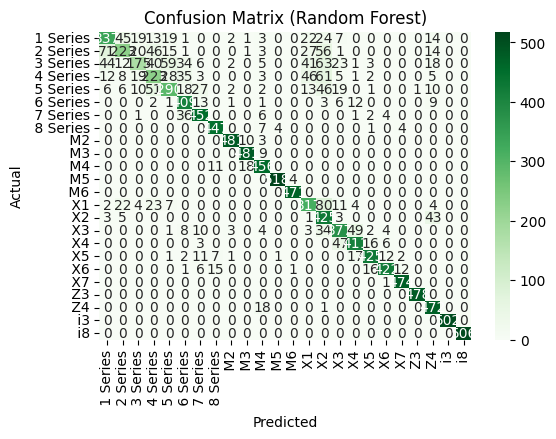

In [11]:
# Confusion Matrix visual
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

PREDIKSI MANUAL DARI USER

In [15]:
# === PREDIKSI MANUAL (INPUT DARI USER) ===

print("\n=== PREDIKSI MANUAL ===")

# Input data dari user
year = int(input("Masukkan tahun mobil : "))
price = float(input("Masukkan harga mobil (mata uang Inggris (£)): "))
transmission = input("Masukkan jenis transmisi (Manual / Automatic / Semi-Auto): ").strip()
mileage = float(input("Masukkan jarak tempuh (mileage): "))
fuelType = input("Masukkan jenis bahan bakar (Petrol / Diesel / Hybrid / Electric / Other): ").strip()
tax = float(input("Masukkan pajak kendaraan (tax (mata uang Inggris (£))): "))
mpg = float(input("Masukkan konsumsi bahan bakar (mpg (berapa mil yang ditempuh per galon bahan bakar)): "))
engineSize = float(input("Masukkan ukuran mesin (engineSize): "))

# Buat DataFrame dari input
input_data = pd.DataFrame([{
    'year': year,
    'price': price,
    'mileage': mileage,
    'tax': tax,
    'mpg': mpg,
    'engineSize': engineSize,
    'transmission': transmission,
    'fuelType': fuelType
}])

# Encode kategori agar sesuai dengan model
input_encoded = pd.get_dummies(input_data, columns=['transmission', 'fuelType'])
input_encoded = input_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# Normalisasi dengan scaler yang sama
input_scaled = scaler.transform(input_encoded)

# Prediksi
prediction = model.predict(input_scaled)
predicted_label = le.inverse_transform(prediction)[0]

print(f"\n🚗 Prediksi Model Mobil BMW: {predicted_label}")


=== PREDIKSI MANUAL ===
Masukkan tahun mobil : 2010
Masukkan harga mobil (mata uang Inggris (£)): 8000
Masukkan jenis transmisi (Manual / Automatic / Semi-Auto): Manual
Masukkan jarak tempuh (mileage): 1200000
Masukkan jenis bahan bakar (Petrol / Diesel / Hybrid / Electric / Other): Hybrid
Masukkan pajak kendaraan (tax (mata uang Inggris (£))): 100
Masukkan konsumsi bahan bakar (mpg (berapa mil yang ditempuh per galon bahan bakar)): 60.0
Masukkan ukuran mesin (engineSize): 1.5

🚗 Prediksi Model Mobil BMW:  2 Series
